# EM Algorithm

The EM algorithm, short for Expectation-Maximization algorithm, is a powerful computational method for estimating the parameters of statistical models, particularly those involving latent or hidden variables. It was first introduced by Arthur Dempster, Nan Laird, and Donald Rubin in their seminal 1977 paper "Maximum Likelihood from Incomplete Data via the EM Algorithm."

The EM algorithm is widely used in various fields, including statistics, machine learning, and artificial intelligence, to solve a wide range of problems, such as clustering, classification, and image recognition. The algorithm is particularly useful when dealing with incomplete or missing data, where some of the observations are not fully observed or measured.

The basic idea of the EM algorithm is to iteratively compute two steps: the expectation step, where the algorithm estimates the missing data or latent variables based on the current model parameters, and the maximization step, where the algorithm updates the model parameters based on the estimated latent variables. By repeating these two steps, the algorithm gradually converges to the maximum likelihood estimates of the model parameters.

The EM algorithm has been widely studied and extended, and many variants and applications have been proposed over the years. It is a powerful and flexible tool that can be applied to a wide range of problems, and it continues to be an active area of research in statistics and machine learning.


The log-likelihood based on the N training cases is:

$$  l(\theta; Z) = \sum^N_{i=1}{log[(1-\pi) \phi_1 (y_i) +  \pi \phi_2 (y_i)]} $$

Direct maximization of ℓ(θ; Z) is quite difficult numerically, because of
the sum of terms inside the logarithm. There is, however, a simpler approach. We consider unobserved latent variables ∆i taking values 0 or 1 : if ∆i = 1 then Yi comes from model 2, otherwise it comes from model 1. Suppose we knew the values of the ∆i’s.
Then the log-likelihood
would be:

$$  l(\theta; Z, \Delta) = \sum^N_{i=1}{[(1-\Delta_i) log \phi_1(y_i) + \Delta_i log(\phi_2(y_i)]} + \sum^N_{i=1}{[(1-\Delta_i) log (1- \pi) + \Delta_i log \pi]} $$

Since the values of the ∆i ’s are actually unknown, we proceed in an iterative fashion, substituting for each ∆i its expected value

$$  \gamma_i(\theta) = E(\Delta_i | \theta, Z)  $$

also called the responsibility of model 2 for observation i. 
In the expectation step, we do a soft assignment of each observation to each model: the current estimates of the parameters are used to assign responsibilities according to the relative density of the training points under each model. In the maximization step, these responsibilities are used in weighted maximum-likelihood fits to update the estimates of the parameters.

# Converting Outlier Score into Probabilities

The **ensemble method** is a technique in machine learning that involves combining multiple models to improve predictive accuracy and reduce overfitting. Ensemble methods work by combining the predictions of several individual models, such as decision trees, neural networks, or support vector machines, into a single prediction. This can be done by averaging the predictions, using a majority vote, or using more advanced methods such as stacking or boosting.

Ensemble methods are useful because they can improve the performance of individual models by reducing their biases and variances. By combining the predictions of multiple models, ensemble methods can capture different aspects of the data and produce more robust and accurate predictions. This can be especially useful in cases where individual models are prone to overfitting or are limited in their representational power.

One application of ensemble methods is in outlier detection, where the goal is to identify data points that are significantly different from the rest of the data. Ensembling outlier detection methods can be challenging because different models may have different biases, strengths, and weaknesses, and may produce different types of outliers. For example, some models may be better at detecting local outliers, while others may be better at detecting global outliers.

Ensembling **outlier scores** by different models can be difficult because it requires careful selection and weighting of the individual models to ensure that they complement each other and do not produce conflicting or redundant results. It also requires a comprehensive evaluation of the ensemble's performance on **various types of outliers and data distributions**, as well as the identification of potential sources of errors and uncertainties.

Despite these challenges, ensembling outlier detection methods can lead to more accurate and robust results, especially in cases where individual models are limited or prone to errors. By combining the strengths of multiple models, ensembling can help to improve the accuracy, reliability, and interpretability of outlier detection methods, and enable their effective use in various applications, such as fraud detection, anomaly detection, and cybersecurity.

A way to solve the different scale and distribution of the outlier score is to use the EM algorithm assuming that the nominal data (not anomaly) came from an exponential distribution, instead the outlier observations came from a normal distribution.

See **"Converting Output Scores from Outlier Detection Algorithms into Probability Estimates"** for more information. 

## Implementation Algorithm

In [7]:
import numpy as np
import random
import statistics 
def gaussian_pdf(x, mu, sigma):
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-((x - mu)**2 / (2 * sigma**2))) 

def exponential_pdf(x, lambd):
    if x >= 0:
        return lambd * np.exp(-(lambd * x)) 
    else:
        return 0 

def mixture_pdf(x, alpha, mu, sigma, lambd):
    return alpha * gaussian_pdf(x, mu, sigma) + (1 - alpha) * exponential_pdf(x, lambd)


def log_likelihood(F, T, alpha, mu, sigma, lambd):
    n = len(F)
    log_likelihood = 0
    for i in range(n):
        fi = F[i]
        ti = T[i]
        log_likelihood += np.log(alpha * gaussian_pdf(fi, mu, sigma)) + np.log((1 - alpha) * exponential_pdf(fi, lambd))
    return log_likelihood




def em_algorithm(F, alpha, mu, sigma, lambd, max_iter=1000, epsilon=1e-6):

    ll_old = 0
    for iter in range(max_iter):
        # E-step
        t = np.zeros(len(F))
        for i in range(len(F)):
            fi = F[i]
            
            #posterior
            p = mixture_pdf(fi, alpha, mu, sigma, lambd)
            t[i] = (alpha * gaussian_pdf(fi, mu, sigma)) / (p)
        
        
        # M-step
        alpha = np.mean(t)
        #print("alpha: ", alpha)
        mu = np.sum(t * F) / np.sum(t)
        sigma = np.sqrt(np.sum(t * (F - mu)**2) / np.sum(t))
        lambd = np.sum(1-t) / np.sum((1-t) * (F))
        
        # Check convergence
        ll = log_likelihood(F, t, alpha, mu, sigma, lambd)
        #print("log-lokelihood: ", ll)
        
        if abs(ll - ll_old) < epsilon:
            break
        ll_old = ll
    return alpha, mu, sigma, lambd, t, ll

 


def converting_outlier_score (samples):
    #initialization
    max_ll = float('-inf')
    
    #iteration for different random inizialization values
    for iter in range (10):

        #randomly inizialization mean by a uniform distrubtion
        mu_rand = random.uniform(min(samples), max(samples))
        
        #randomly inizialization sigma by a sample vairance of a sub-set equal to the 10% of the entire sample
        sort_samp = sorted(samples)
        sigma_rand = np.sqrt(statistics.variance(random.sample(sort_samp, round(0.1*len(samples)))))
        #randomly inizialization lambda by a uniform distrubtion
        lambda_rand = random.uniform(0.5, 3)
        
        alpha, mu, sigma, lambd, t, ll = em_algorithm(F = samples, alpha = 0.5, mu = mu_rand, sigma = sigma_rand, lambd = lambda_rand)
        #print(alpha, mu, sigma, lambd)
        
        #storage best estimation
        if ll > max_ll:
            max_ll = ll
            alpha_final, mu_final, sigma_final, lambd_final, t_final, ll_final = alpha, mu, sigma, lambd, t, ll

    return alpha_final, mu_final, sigma_final, lambd_final, t_final, ll_final 



## Simulated data

We will generate a dataset cames from two different distribution:
* Normal distribution with mu equal to 15 and standard deviation equal to 5
* Exponential distribution with lambda equal to 0.7

And alpha equal to 0.1

Estimation alpha =  0.10834436709097571
Estimation mu =  14.673245609663649
Estimation sigma =  4.394353155687286
Estimation lambda =  0.6645221553468385


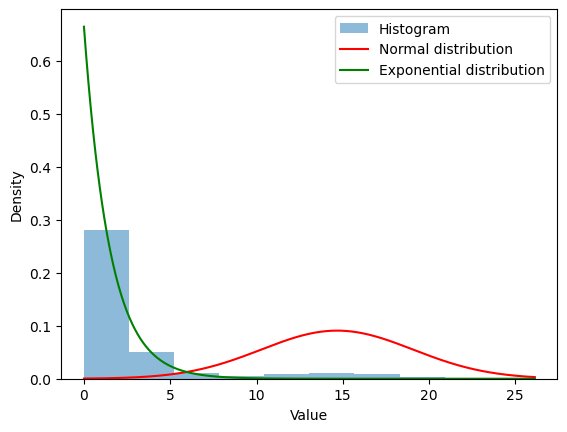

In [8]:

import matplotlib.pyplot as plt
from scipy.stats import norm, expon

np.random.seed(0)

mean_normal = 15
std_normal = 5
rate_lambda= 1/0.7

mixing_proportion = 0.1
n_samples = 1000

z = np.random.binomial(1, mixing_proportion, size=n_samples)
samples = np.zeros(n_samples)
samples[z == 1] = np.random.normal(mean_normal, std_normal, size=(z == 1).sum())
samples[z == 0] = np.random.exponential(rate_lambda, size=(z == 0).sum())


alpha_final, mu_final, sigma_final, lambd_final, t_final, ll_final = converting_outlier_score(samples)

print("Estimation alpha = ", alpha_final)
print("Estimation mu = ", mu_final)
print("Estimation sigma = ", sigma_final)
print("Estimation lambda = ", lambd_final)


plt.hist(samples, density=True, alpha=0.5, label='Histogram')

x = np.linspace(min(samples), max(samples), 1000)
# Plot the theoretical normal distribution 
normal_pdf = norm.pdf(x, mu_final, sigma_final)
plt.plot(x, normal_pdf, 'r-', label='Normal distribution')

# Plot the theoretical exponential distribution
exponential_pdf = expon.pdf(x, scale=1/lambd_final)
plt.plot(x, exponential_pdf, 'g-', label='Exponential distribution')

# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()